In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

pd.set_option("display.max_columns", None)

#### Dataset description
Dataset collected from Uzum Market Marketplace
- Features
1. normalized_review_text -> reviews left in Uzbek, Russian
2. rating -> 5 classes(exclellent, good, fair, poor, very poor)

In [2]:
# loading dataset
reviews_df = pd.read_parquet("./data/uzum_dataset.parquet", engine='pyarrow')

In [3]:
reviews_df["num_chars"] = reviews_df["normalized_review_text"].astype(str).str.len()
reviews_df["num_words"] = reviews_df["normalized_review_text"].astype(str).str.split().apply(len)

In [4]:
class_balance_df = reviews_df["rating"].value_counts(normalize=True).reset_index()

class_balance_df

,rating,proportion
0,excellent,0.717130
1,very poor,0.149220
2,good,0.052071
3,fair,0.044870
4,poor,0.036709


Text(0.5, 1.0, 'Class distribution')

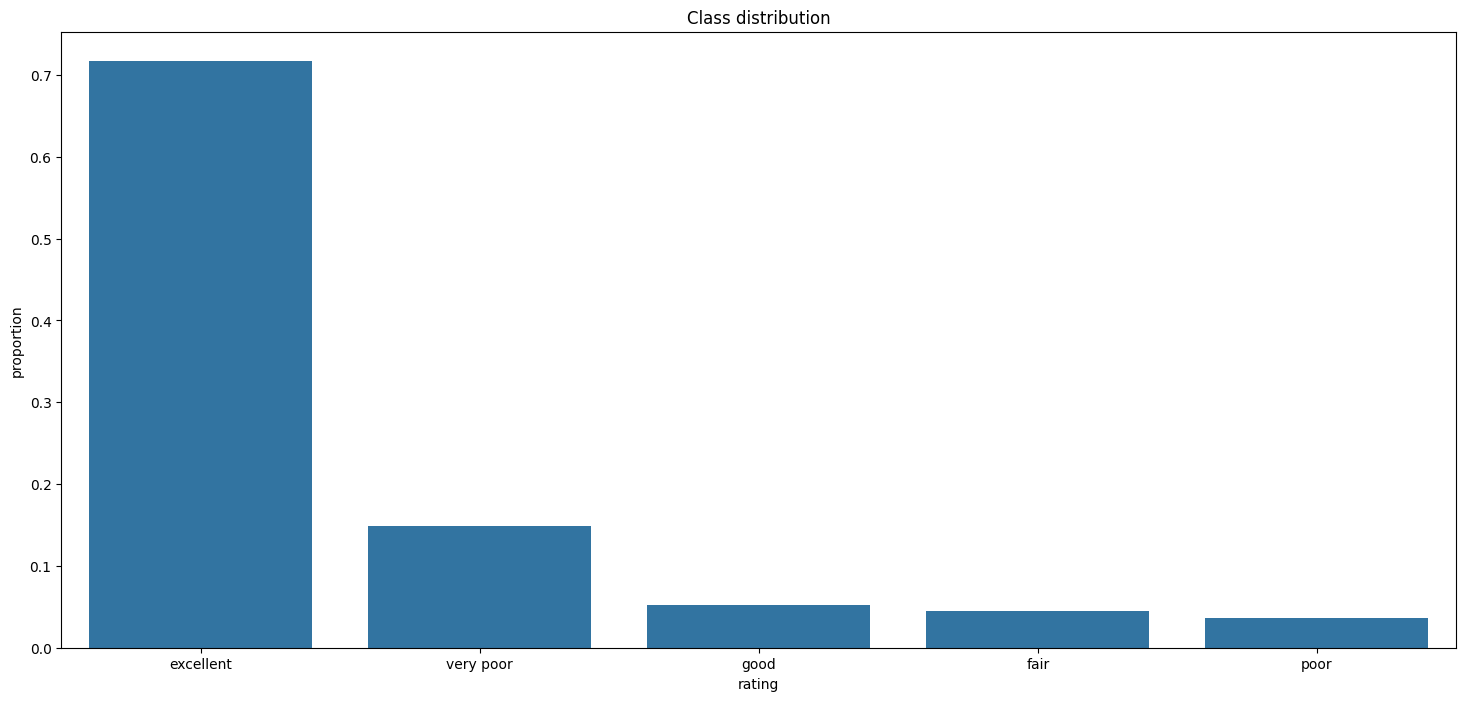

In [5]:
plt.figure(figsize=(18, 8))
sns.barplot(class_balance_df, x="rating", y="proportion")
plt.title("Class distribution")

In [6]:
reviews_df["num_words"].mean()

5.764822476721633

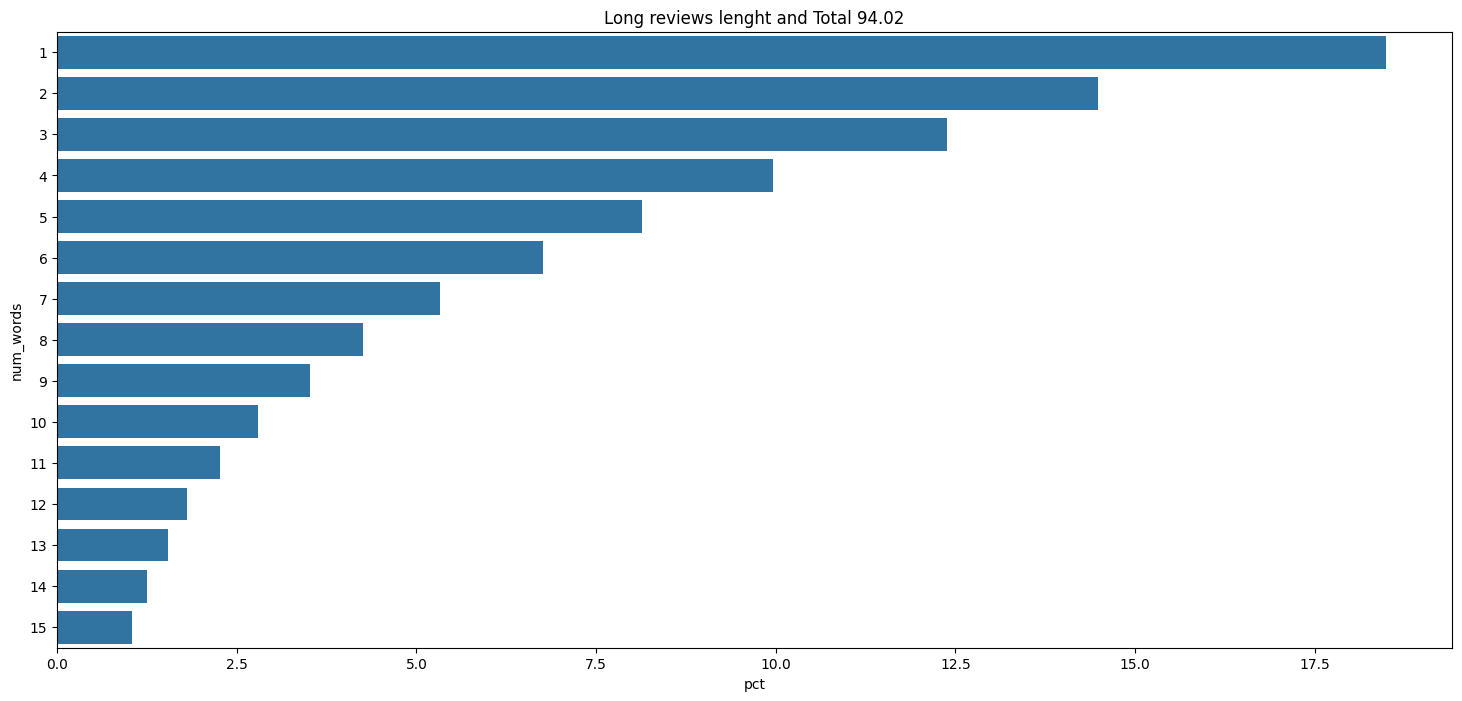

In [7]:
word_count_distribution_df = reviews_df.groupby("num_words").size().reset_index(name="count")
total_count = word_count_distribution_df["count"].sum()

word_count_distribution_df["pct"] = round(word_count_distribution_df["count"] * 100 / total_count, 2)

most_reviews_length = word_count_distribution_df.iloc[:15, :].drop('count', axis=1)

total_most_reviews_lenght_pct = most_reviews_length["pct"].sum()

most_reviews_length["num_words"] = most_reviews_length["num_words"].astype(str)

plt.figure(figsize=(18, 8))
sns.barplot(most_reviews_length, y="num_words", x="pct")
plt.title(f"Long reviews lenght and Total {total_most_reviews_lenght_pct:.2f}")
plt.show()

In [6]:
rating_map = {
    'very poor' : 0,
    'poor' : 0,
    'fair' : 1,
    'good' : 2,
    'excellent' : 2
}

reviews_df["rating"] = reviews_df["rating"].map(rating_map)

Text(0.5, 1.0, 'Class distribution')

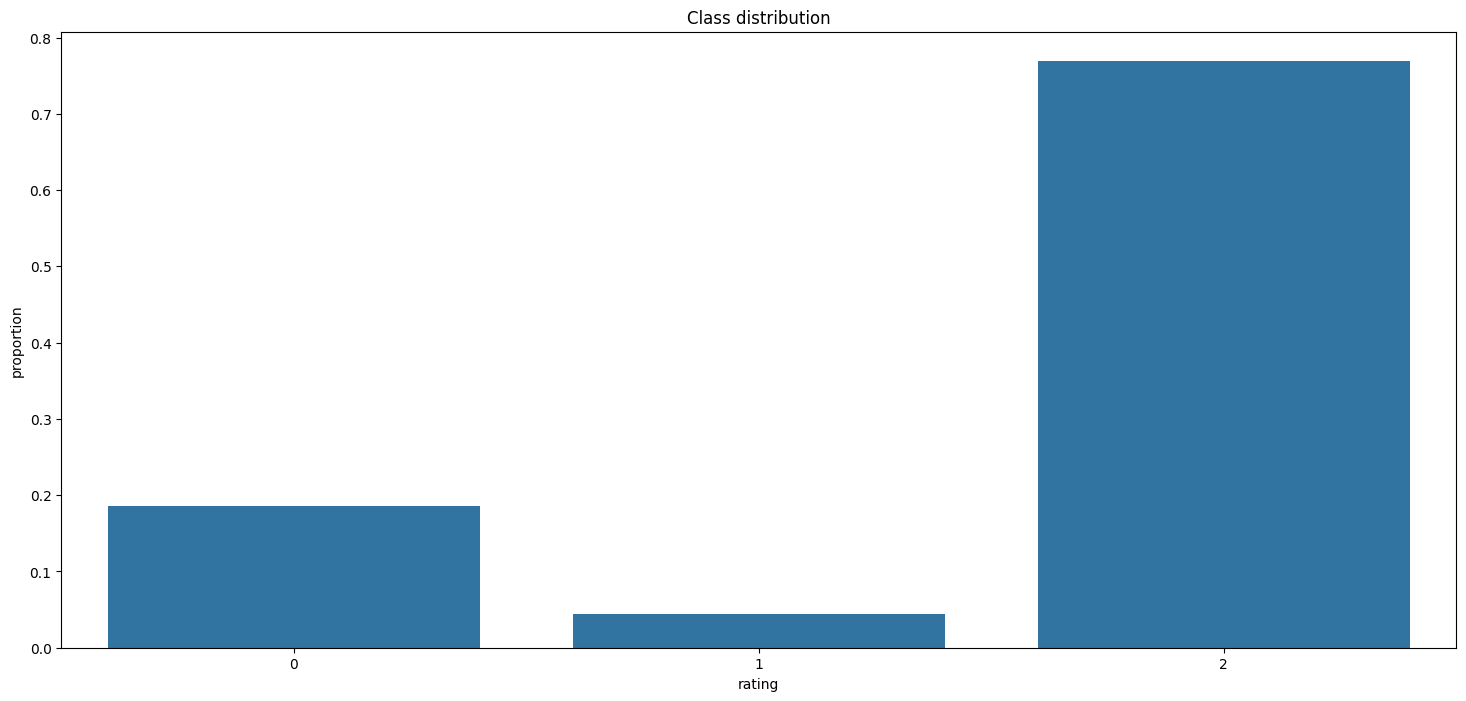

In [7]:
rating_dist_3cl = reviews_df["rating"].value_counts(normalize=True).reset_index()

plt.figure(figsize=(18, 8))
sns.barplot(rating_dist_3cl, x="rating", y="proportion")
plt.title("Class distribution")

## Cleaning text
- first, checking for unnessary chars
- then, filtering
- then, going to word level

In [8]:
text = reviews_df["normalized_review_text"].tolist()

chars = sorted(list(set("\n".join(text))))

print("Total Unique Characters: ", len(chars))
print(chars)

Total Unique Characters:  233
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '²', '³', '¹', 'à', 'á', 'â', 'ã', 'ç', 'è', 'é', 'ë', 'ì', 'í', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ', 'ď', 'ĝ', 'ğ', 'ġ', 'ģ', 'ĥ', 'ı', 'ĵ', 'ķ', 'ĺ', 'ļ', 'ń', 'ň', 'ō', 'ŏ', 'ő', 'ŕ', 'ś', 'ş', 'ũ', 'ū', 'ů', 'ź', 'ž', 'ƙ', 'ǒ', 'ǫ', 'ǵ', 'ɑ', 'ɓ', 'ə', 'ɢ', 'ɪ', 'ɴ', 'ʀ', 'ʏ', 'ʔ', 'ʕ', 'ʖ', 'ʙ', 'ʜ', 'ʟ', '̇', 'ͳ', 'α', 'β', 'ι', 'λ', 'ο', 'π', 'υ', 'ω', 'щ', 'є', 'і', 'ґ', 'ҙ', 'ң', 'ү', 'ұ', 'ҷ', 'һ', 'ә', 'ө', 'ӯ', 'ե', 'հ', 'ղ', 'տ', 'א', 'ב', 'ד', 'ה', 'ו', 'י', 'כ', 'ל', 'ם', 'מ', 'נ', 'ס', 'פ', 'ץ', 'ר', 'ת', 'ء', 'أ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ر', 'ز', 'س', 'ش', 'ع', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'ಠ', 'ಥ', 'ෆ', 'ค', '๑', 'ღ', 'ᅠ', 'ᐛ'

### Comments:
- there some arabic scripts as well, some mixed type chars even for human eye can read as A but it comes in a different format
- for example: 'ã' -> actually it is a

In [9]:
import regex as re

# defining allowed scripts
latin = r"\p{Script=Latin}"
cyrillic = r"\p{Script=Cyrillic}"
digits = r"\p{Number}"

# combining into a single pattern
allowed_re = re.compile(fr"(?:{latin}|{cyrillic}|{digits})$")

# filter characters
cleaned = [ch for ch in chars if allowed_re.match(ch)]

# my manually selected unnesassary chars
final_clean = [ 'ø', 'ʔ','ʕ','ʖ','ᴥ','ᵕ','⅚','ᴗ']

clean_chars = [c for c in cleaned if c not in final_clean]
print(clean_chars)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '²', '³', '¹', 'à', 'á', 'â', 'ã', 'ç', 'è', 'é', 'ë', 'ì', 'í', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ', 'ď', 'ĝ', 'ğ', 'ġ', 'ģ', 'ĥ', 'ı', 'ĵ', 'ķ', 'ĺ', 'ļ', 'ń', 'ň', 'ō', 'ŏ', 'ő', 'ŕ', 'ś', 'ş', 'ũ', 'ū', 'ů', 'ź', 'ž', 'ƙ', 'ǒ', 'ǫ', 'ǵ', 'ɑ', 'ɓ', 'ə', 'ɢ', 'ɪ', 'ɴ', 'ʀ', 'ʏ', 'ʙ', 'ʜ', 'ʟ', 'щ', 'є', 'і', 'ґ', 'ҙ', 'ң', 'ү', 'ұ', 'ҷ', 'һ', 'ә', 'ө', 'ӯ', '๑', 'ᴀ', 'ᴄ', 'ᴅ', 'ᴇ', 'ᴊ', 'ᴋ', 'ᴍ', 'ᴏ', 'ᴘ', 'ᴛ', 'ᴜ', 'ᴠ', 'ᴡ', 'ᴢ', '⁰', '⁴', '⁵', '⁶']


#### Comments:
- although we have cleaned with regex automatically, still there are issue , needs a manul job

In [12]:
# manually collected chars to make as a common chars
latin_map = {
    "à": "a", "á": "a", "â": "a", "ã": "a",
    "ç": "c",
    "è": "e", "é": "e", "ë": "e",
    "ì": "i", "í": "i",
    "ñ": "n",
    "ò": "o", "ó": "o", "ô": "o", "õ": "o", "ö": "o",
    "ù": "u", "ú": "u", "û": "u", "ü": "u",
    "ý": "y", "ÿ": "y",

    "ĝ": "g'", "ğ": "g'", "ġ": "g'", "ģ": "g'",
    "ĥ": "h",
    "ı": "i",
    "ĵ": "j",
    "ķ": "k",
    "ĺ": "l", "ļ": "l",
    "ń": "n", "ň": "n",
    "ō": "o'", "ŏ": "o'", "ő": "o'",
    "ŕ": "r",
    "ś": "s", "ş": "sh",
    "ũ": "u", "ū": "u", "ů": "u",
    "ź": "z", "ž": "j",  # note: ž is pronounced like "j"
    "ǒ": "o'", "ǫ": "q",
    "ǵ": "g'",
    "ɓ": "b",    # approximate
    "ə": "e",    # Azerbaijani ə → a
    '²' : '2',
    '³' :'3',
    '¹' : '1',
     'ď' : 'd',

     'ɢ' : 'g',
 'ɪ' : 'i',
 'ɴ': 'n',
 'ʀ' : 'r',
 'ʏ' : 'y',
 'ʜ' : 'h',
 'ʟ' : 'l',
    'ө': 'o',
    'ᴀ' : 'a',
 'ᴄ' : 'c',
 'ᴅ' : 'd',
 'ᴇ' : 'e',
 'ᴊ': 'j',
 'ᴋ': 'k',
 'ᴍ' :'m',
 'ᴏ' :'o',
 'ᴘ' : 'p',
 'ᴛ' :'t',
 'ᴜ' :'u',
     '⁰' : '0',
 '⁴' : '4',
 '⁵' : '5'
}


normalized_chars = []

for c in clean_chars:
  if c in latin_map:
    normalized_chars.append(latin_map[c])
  else:
    normalized_chars.append(c)


print("Total Unique cleaned chars", len(sorted(list(set(normalized_chars)))))
print(normalized_chars)

Total Unique cleaned chars 59
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '2', '3', '1', 'a', 'a', 'a', 'a', 'c', 'e', 'e', 'e', 'i', 'i', 'n', 'o', 'o', 'o', 'o', 'o', 'u', 'u', 'u', 'u', 'y', 'y', 'd', "g'", "g'", "g'", "g'", 'h', 'i', 'j', 'k', 'l', 'l', 'n', 'n', "o'", "o'", "o'", 'r', 's', 'sh', 'u', 'u', 'u', 'z', 'j', 'ƙ', "o'", 'q', "g'", 'ɑ', 'b', 'e', 'g', 'i', 'n', 'r', 'y', 'ʙ', 'h', 'l', 'щ', 'є', 'і', 'ґ', 'ҙ', 'ң', 'ү', 'ұ', 'ҷ', 'һ', 'ә', 'o', 'ӯ', '๑', 'a', 'c', 'd', 'e', 'j', 'k', 'm', 'o', 'p', 't', 'u', 'ᴠ', 'ᴡ', 'ᴢ', '0', '4', '5', '⁶']


### Comments:
- at most, i could able to cleaned chars

## Now making or cleaning them in Word-Level

In [10]:
import regex as re

# ---------- Allowed chars ----------
latin = r"\p{Latin}"
cyrillic = r"\p{Cyrillic}"
digits = r"\p{Number}"

# allow latin + cyrillic + digits + spaces
allowed_re = re.compile(fr"(?:{latin}|{cyrillic}|{digits}|\s)")

# final cleaning chars, but no
final_clean = {'ø','ʔ','ʕ','ʖ','ᴥ','ᵕ','⅚','ᴗ'}

# manual cleaning
latin_map = {
    "à": "a", "á": "a", "â": "a", "ã": "a",
    "ç": "c",
    "è": "e", "é": "e", "ë": "e",
    "ì": "i", "í": "i",
    "ñ": "n",
    "ò": "o", "ó": "o", "ô": "o", "õ": "o", "ö": "o",
    "ù": "u", "ú": "u", "û": "u", "ü": "u",
    "ý": "y", "ÿ": "y",
    "ĝ": "g'", "ğ": "g'", "ġ": "g'", "ģ": "g'",
    "ĥ": "h",
    "ı": "i",
    "ĵ": "j",
    "ķ": "k",
    "ĺ": "l", "ļ": "l",
    "ń": "n", "ň": "n",
    "ō": "o'", "ŏ": "o'", "ő": "o'",
    "ŕ": "r",
    "ś": "s", "ş": "sh",
    "ũ": "u", "ū": "u", "ů": "u",
    "ź": "z", "ž": "j",
    "ǒ": "o'", "ǫ": "q",
    "ǵ": "g'",
    "ɓ": "b",
    "ə": "e",
    '²': '2',
    '³': '3',
    '¹': '1',
    'ď': 'd',
    'ɢ': 'g',
    'ɪ': 'i',
    'ɴ': 'n',
    'ʀ': 'r',
    'ʏ': 'y',
    'ʜ': 'h',
    'ʟ': 'l',
    'ө': 'o',
    'ᴀ': 'a',
    'ᴄ': 'c',
    'ᴅ': 'd',
    'ᴇ': 'e',
    'ᴊ': 'j',
    'ᴋ': 'k',
    'ᴍ': 'm',
    'ᴏ': 'o',
    'ᴘ': 'p',
    'ᴛ': 't',
    'ᴜ': 'u',
    '⁰': '0',
    '⁴': '4',
    '⁵': '5'
}


def normalize_text(text: str) -> str:
    out = []
    for ch in text:
        # skip unwanted characters
        if ch in final_clean:
            continue

        # keep only allowed characters (latin, cyrillic, digits, spaces)
        if not allowed_re.fullmatch(ch):
            continue

        # map special latin → uzbek letters
        out.append(latin_map.get(ch, ch))

    return "".join(out)


In [11]:
import swifter

reviews_df['clean_text'] = reviews_df["normalized_review_text"].astype(str).swifter.apply(normalize_text)

Pandas Apply:   0%|          | 0/352151 [00:00<?, ?it/s]

In [12]:
# checking wether our job is correctly done or no, if so they should match with previus ones
normalized_characters = sorted(list(set("\n".join(reviews_df["clean_text"].tolist()))))

print("Total unique characters after cleaning: ", len(normalized_characters))

Total unique characters after cleaning:  59


In [13]:
reviews_df = reviews_df[['clean_text', 'rating']].rename(columns={'clean_text' : 'review_text'})

In [17]:
reviews_df.head()

,review_text,rating
0,rahmat juda yoqdi,2
1,shuni qoygandan keyin maza qildik,2
2,rahmat zor ekan,2
3,super,2
4,ajoyib maxsulot,2


### Checking for 10 most common words

In [18]:
from collections import Counter

words = " ".join(reviews_df["review_text"]).lower().split()
word_freq = Counter(words)

word_freq.most_common(10)

[('zor', 73517),
 ('ekan', 68166),
 ('juda', 51917),
 ('yaxshi', 50156),
 ('raxmat', 34899),
 ('yoqdi', 25439),
 ('ham', 22962),
 ('gap', 22792),
 ('rahmat', 22532),
 ('zur', 20567)]

### Tokenizing the text
- we will use BPE
- pad_idx -> add special token
- then converting to PyTorch tensor

In [14]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers

pad_token = '<pad>'
unk_token = '<unk'

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(
    vocab_size=30000,
    special_tokens=[pad_token, unk_token]
)

# traning on our dataset
tokenizer.train_from_iterator(text, trainer)

PAD_ID = tokenizer.token_to_id(pad_token)
UNK_ID = tokenizer.token_to_id(unk_token)

In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

block_size = 80

def encode_and_padding(text):
    ids = tokenizer.encode(text).ids[:block_size]
    ids += [PAD_ID] * (block_size - len(ids))
    return ids


X_padded = [encode_and_padding(t) for t in reviews_df["review_text"]]


data = torch.tensor(X_padded, dtype=torch.long)
targets = torch.tensor(reviews_df['rating'].values, dtype=torch.long)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    data, targets, test_size=0.2, random_state=42
)

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

### First Model
- bag of words, simple and good for baseline modeling

In [17]:
vocab_size = vocab_size = tokenizer.get_vocab_size()
num_classes = 3

class BoWClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(vocab_size, num_classes)

    def forward(self, x):
        return self.fc(x)

In [25]:
def to_bow(x, vocab_size, pad_id=0):
    bow = torch.zeros(x.size(0), vocab_size, device=x.device)
    for i, row in enumerate(x):
        mask = row != pad_id
        bow[i].scatter_add_(
            0,
            row[mask],
            torch.ones_like(row[mask], dtype=torch.float)
        )
    return bow

In [26]:
model = BoWClassifier()

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 5

for epoch in range(epochs):
    # train
    model.train()
    train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb, yb

        xb_bow = to_bow(xb, vocab_size, PAD_ID)

        optimizer.zero_grad()
        logits = model(xb_bow)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb, yb

            xb_bow = to_bow(xb, vocab_size, PAD_ID)
            logits = model(xb_bow)
            loss = criterion(logits, yb)

            val_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    val_loss /= len(val_loader)
    acc = correct / total

    print(
        f"epoch {epoch+1}: "
        f"train loss = {train_loss:.4f}, "
        f"val loss = {val_loss:.4f}, "
        f"val acc = {acc:.4f}"
    )

epoch 1: train loss = 0.3914, val loss = 0.3375, val acc = 0.8899
epoch 2: train loss = 0.3129, val loss = 0.3302, val acc = 0.8945
epoch 3: train loss = 0.2965, val loss = 0.3311, val acc = 0.8946
epoch 4: train loss = 0.2868, val loss = 0.3346, val acc = 0.8946
epoch 5: train loss = 0.2798, val loss = 0.3389, val acc = 0.8951
